# 1-D Inference with Redshifts

This notebook outlines how to derive population redshift distributions from a given collection of **redshift probability density functions (PDFs)**. This simple case allows us to introduce most of the critical ideas and extensions that serve as the foundation for $p$-D **photometric PDF** inference.

# Setup

In [1]:
from __future__ import print_function, division
import sys
import pickle
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
from six.moves import range

# import frankenz code
import frankenz

# plot in-line within the notebook
%matplotlib inline

np.random.seed(7)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

# Data

For our proof-of-concept tests, we will use the mock SDSS data we previously generated.

In [3]:
downsample = 10  # downsampling the population
survey = pickle.load(open('../data/mock_sdss_polletta_bpz.pkl', 'rb'))  # load data
types = survey.data['types'][::downsample]
templates = survey.data['templates'][::downsample]
redshifts = survey.data['redshifts'][::downsample]
mags = survey.data['refmags'][::downsample]
Nobs = len(types)

# Population Redshift Density Estimation

For every observed galaxy $g \in \mathbf{g}$, let's assume we have an associated redshift estimate $z_g$ with PDF $P(z_g | z)$. We can construct an estimate for the population redshift distribution $N(z|\mathbf{g})$ by projecting our results onto a relevant **redshift basis** $\lbrace \dots, P(z_h|z) , \dots \rbrace$ indexed by $h \in \mathbf{h}$ via

$$
P(g|h) = P(z_g|z_h) = \frac{P(z_g, z_h)}{P(z_h)} = \frac{\int P(z_g | z) P(z_h | z) P(z) dz}{\sum_{g \in \mathbf{g}} \int P(z_g | z) P(z_h | z) P(z) dz}
$$

## Noiseless Case

In the case where our observations are error-less such that $P(z_g|z) = \delta(z_g - z)$, our prior $P(z)$ is uniform, and our basis is properly normalized such that $P(z_h|z) dz = 1$, this just reduces to

$$ P(z_g|z_h) = \frac{P(z_h|z_g)}{\sum_{g \in \mathbf{g}} P(z_h|z_g)} $$

which is just the value of our redshift basis $P(z_h|z)$ evaluated at $z_g$.

## Basis: Histogram

One common choice of basis is a series of redshift **bins** (i.e. a histogram), which can be modeled as a product of Heavyside functions

$$
P(z_h|z) = \frac{\mathcal{H}(z - z_h^{-})\mathcal{H}(z_h^{+} - z)}{z_h^{+} - z_h^{-}}, \quad z_h^{\pm} = (\bar{z}_h \pm \Delta z_h)/2
$$

where $z_h^{\pm}$ are the bin edges, $\bar{z}_h$ is the bin center, and $\Delta z_h$ is the bin width. In the errorless case above this just evaluates to $1/\Delta z_h$ if $z_h^{-} \leq z_g < z_h^{+}$ and $0$ otherwise.

We can define our projection over this basis using **Bayes Theorem** as

$$
P(h|\mathbf{g}) \equiv \sum_{g \in \mathbf{g}} P(h|g) = \sum_{g \in \mathbf{g}} \frac{P(g|h)P(h)}{P(g)} = \frac{1}{N_h(z_h^{+} - z_h^{-})}\sum_{g \in \mathbf{g}} \mathcal{H}(z_g - z_h^{-})\mathcal{H}(z_h^{+} - z_g)
$$

where we have assumed our **prior** $P(h)$ over our redshift bins is uniform such that the **evidence** $P(g) = \sum_{g \in \mathbf{g}} P(g|h) P(h) = N_g$ is just the number of galaxies "in" bin $h$. Note that our number density $N(h|\mathbf{g}) = N_g \times P(h|\mathbf{g})$.

This formalism might seem somewhat like an overly complicated way to say "count up the number of galaxies in each redshift bin and normalize then", but the generality will prove useful shortly once we start generalizing to other bases.

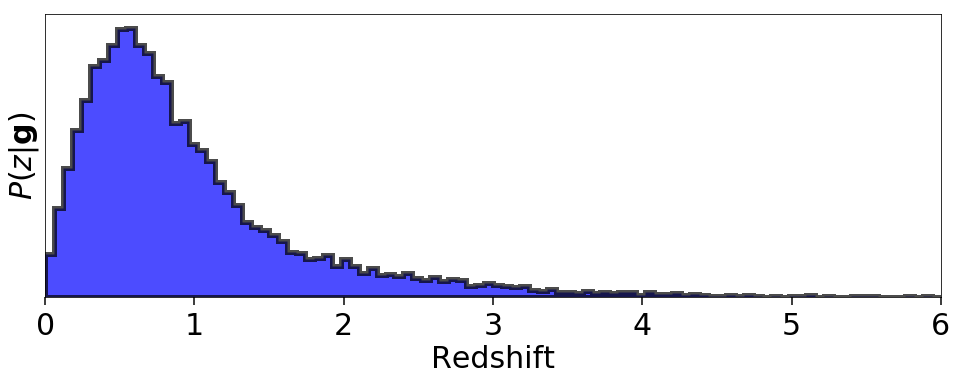

In [4]:
zbins = np.linspace(0, 6, 101)  # redshift bins

# plotting histogrammed representation
plt.figure(figsize=(14, 6))
plt.hist(redshifts, bins=zbins, histtype='stepfilled', lw=5,
         color='blue', alpha=0.7, normed=True, edgecolor='black')
plt.xlabel('Redshift')
plt.xlim([zbins[0], zbins[-1]])
plt.yticks([])
plt.ylabel(r'$P(z|\mathbf{g})$')
plt.tight_layout()

## Basis: Kernel Density

Alternately, we can construct a smooth density estimate by using a **kernel density** as a basis rather than a bin. For instance, we can use a Normal (Gaussian) kernel centered at $\bar{z}_h$ with a smoothing scale of $\sigma_h$ such that $P(z_h|z) = \mathcal{N}(\bar{z}_h|\mu=z, \sigma^2=\sigma^2_h)$. Our new estimator is then

$$
P(h|\mathbf{g}) \propto \sum_{g \in \mathbf{g}} \mathcal{N}(\bar{z}_h|\mu=z_g,\sigma^2=\sigma^2_h) \quad .
$$

This results in a smoother estimator.

Note that due to the nature of the problem, there is a symmetry between assign our kernel density estimates (i.e. "errors") to our redshift basis vs assigning them to our observed redshifts. This allows us to exploit some of the **kernel density estimation (KDE)** functionality of `frankenz` (which is designed to deal with projecting PDFs onto delta functions) to evaluate this.

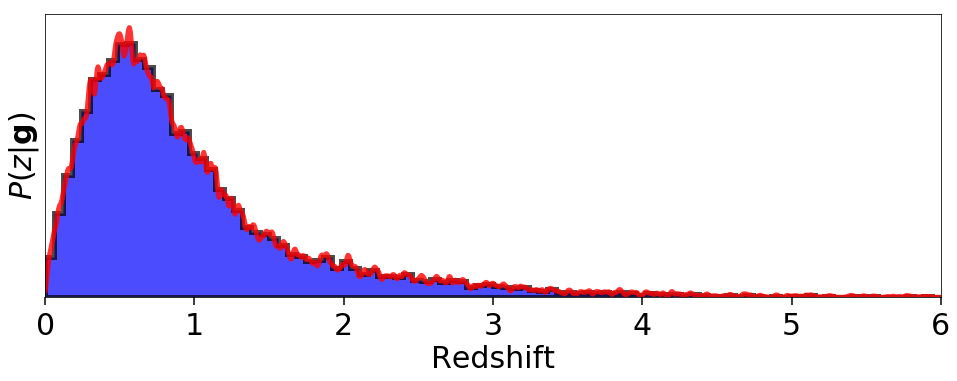

In [5]:
# KDE
zgrid = np.linspace(0., 6., 1001)
pdf = frankenz.pdf.gauss_kde(redshifts, np.ones(Nobs) * 0.01, zgrid)
pdf /= np.trapz(pdf, zgrid)

# plotting
plt.figure(figsize=(14, 6))
plt.hist(redshifts, bins=zbins, histtype='stepfilled', lw=5,
         color='blue', alpha=0.7, normed=True, edgecolor='black')
plt.plot(zgrid, pdf, lw=5, color='red', alpha=0.8)
plt.xlabel('Redshift')
plt.xlim([zbins[0], zbins[-1]])
plt.yticks([])
plt.ylabel('$P(z|\mathbf{g})$')
plt.tight_layout()

## Noisy Case

In the case where $P(z_g|z) \neq \delta(z_g - z)$, we are again left with the more general case

$$
P(g|h) = P(z_g|z_h) = \frac{\int P(z_g | z) P(z_h | z) P(z) dz}{\sum_{g \in \mathbf{g}} \int P(z_g | z) P(z_h | z) P(z) dz}
$$

Let's define our PDFs to be Gaussian $\mathcal{N}(z|\mu=\hat{z}_g, \sigma=\sigma_g)$ centered around noisy estimates $\hat{z}_g$ with error $\hat{\sigma}_g$.

In [6]:
# generate PDFs
sigma = np.random.uniform(0.01, 0.1, size=Nobs)  # width
mu = np.random.normal(redshifts, sigma)  # noisy observation
zpdf = np.array([frankenz.pdf.gaussian(mu[i], sigma[i], zgrid) 
                 for i in range(Nobs)])  # redshift pdfs
zpdf /= np.trapz(zpdf, zgrid)[:,None]  # normalizing

Commonly, it is assumed that stacking these PDFs such that

$$
P(z|\mathbf{g}) \stackrel{?}{=} \frac{1}{N_g} \sum_{g \in \mathbf{g}} \mathcal{N}(z|\mu=\hat{z}_g, \sigma=\hat{\sigma}_g)
$$

will give access to the population distribution. In the context of the general case outlined above, this assumes that (1) our redshift prior $P(z)$ is uniform and (2) each basis $P(z_h|z) = \delta(z_h-z)$ is a delta function.

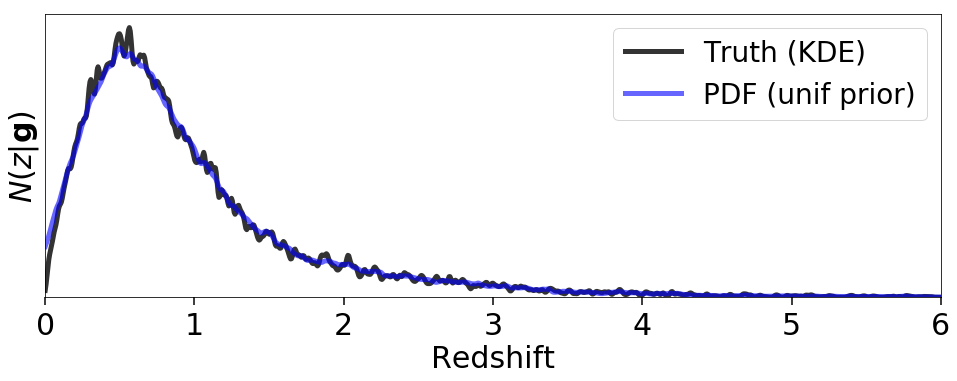

In [7]:
# plotting
plt.figure(figsize=(14, 6))
plt.plot(zgrid, pdf, lw=5, color='black', alpha=0.8,
         label='Truth (KDE)')
plt.plot(zgrid, zpdf.sum(axis=0) / Nobs, lw=5, color='blue',
         alpha=0.6, label='PDF (unif prior)')
plt.xlabel('Redshift')
plt.xlim([zbins[0], zbins[-1]])
plt.yticks([])
plt.ylabel('$N(z|\mathbf{g})$')
plt.ylim([0., None])
plt.legend(fontsize=28, loc='best')
plt.tight_layout()

Now that we're using PDFs instead of the true observed estimates, we can see this is not actually a fully accurate reconstruction of the true PDF -- our noise broadens the estimated population redshift distribution (especially at the low redshift end). To properly account for this, we need to (re-)introduce a prior $P(z)$. Let's use the "true" redshift distribution computed using KDE.

In [8]:
# apply prior
znew = zpdf.copy()
for i in range(Nobs):
    znew[i] *= pdf
    znew[i] /= np.trapz(znew[i], zgrid)

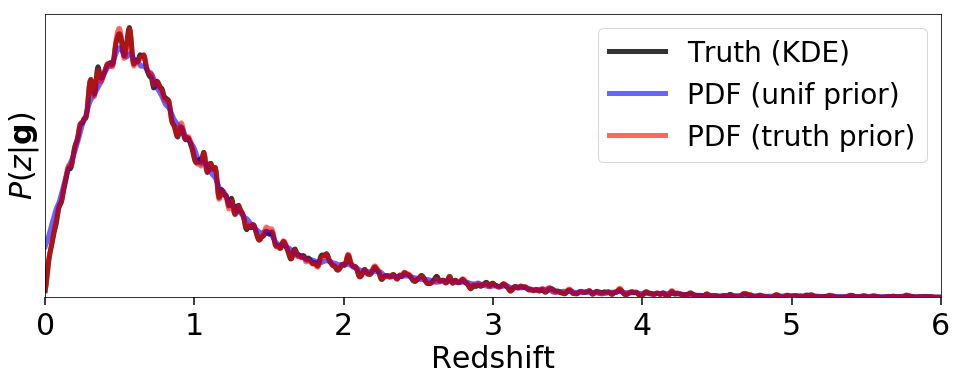

In [9]:
# plotting
plt.figure(figsize=(14, 6))
plt.plot(zgrid, pdf, lw=5, color='black', alpha=0.8,
         label='Truth (KDE)')
plt.plot(zgrid, zpdf.sum(axis=0) / Nobs, lw=5, color='blue',
         alpha=0.6, label='PDF (unif prior)')
plt.plot(zgrid, znew.sum(axis=0) / Nobs, lw=5, color='red',
         alpha=0.6, label='PDF (truth prior)')
plt.xlabel('Redshift')
plt.xlim([zbins[0], zbins[-1]])
plt.yticks([])
plt.ylabel('$P(z|\mathbf{g})$')
plt.ylim([0., None])
plt.legend(fontsize=28, loc='best')
plt.tight_layout()

As expected, using the true distribution as a prior reproduces the original result quite well. The problem, of course, is that in practice we have no idea what the prior should be.

# From Grids to Samples

So far we've assumed that our basis functions indexed by $h \in \mathbf{h}$ correspond to a grid in redshift $z_h \in \mathbf{z}$. Above, we found that to properly reproduce the "correct" $P(z|\mathbf{g})$ we need to incorporate a redshift prior $P(z)$. Given our discrete grid, this translates to a set of discrete priors $P(z_h) \equiv P(h)$ over $\mathbf{h}$, where our basis over $\mathbf{h}$ just *happens* to correspond to a grid in redshift $\mathbf{z}$. As stated above, this is just

$$
P(g|h) = \frac{\int P(z_g | z) P(z_h | z) P(z) dz}{\sum_{g \in \mathbf{g}} \int P(z_g | z) P(z_h | z) P(z) dz}
$$

We now want to take advantage of two key insights:
1. Our choice of basis is arbitrary, and we're free to pick our $h \in \mathbf{h}$ and their corresponding $\lbrace \dots, P(z_h|z), \dots \rbrace$ however we'd like.
2. Our basis itself can indirectly provide information on our prior.

In particular, if we assume that $h \in \mathbf{h}$ is a **(Poisson) point process**, where our objects are drawn from an underlying $P(z)$ distribution (i.e. the "true" prior), then aggregating information over these redshift samples is *fundamentally equivalent* in the limit where $n \rightarrow \infty$ to weighting a set of predictions computed over a redshift grid $\mathbf{z}$ by our corresponding prior $P(\mathbf{z})$. In other words, we just transition from a prior imposed directly via $P(z)$ to a prior imposed indirectly via the associated number densities of objects in $\mathbf{h}$.

From a **machine learning** perspective, we can interpret these samples as a **training set** that we exploit to make predictions. We'll start using a bit more of this terminology to emphasize some of the connections between machine learning and this point process formalism as we move further throughout the notebooks.

## Noiseless Samples

We first consider the case where our samples are noiseless and drawn directly from the redshift distribution of interest (i.e. $P(z_h|z) = \delta(z_h - z)$. As argued above, we'll take $P(h)=1$ for all $h \in \mathbf{h}$. Our posterior then becomes

$$
P(h|g) = \frac{P(h,g)}{P(g)} = \frac{\int P(g|z) P(z|h) P(h) dz}{\sum_{h \in \mathbf{h}} \int P(g|z) P(z|h) P(h) dz} = \frac{\mathcal{N}(\hat{z}_g|\mu=z_h,\sigma=\hat{\sigma}_g)}{\sum_{h \in \mathbf{h}} \mathcal{N}(\hat{z}_g|\mu=z_h,\sigma=\hat{\sigma}_g)} 
$$

In [10]:
# draw samples from our basis
Ntrain = 2500  # number of training samples
cdf = pdf.cumsum()  # compute unnormalized CDF
cdf /= cdf[-1]  # normalize CDF
ztrain = np.interp(np.random.rand(Ntrain), cdf, zgrid)  # sample from inverse CDF

In [11]:
# stack results
ztrain_wt = np.zeros(Ntrain)
evid_obs = np.zeros(Nobs)
chi2_obs = np.zeros(Nobs)
for i in range(Nobs):
    if i % 1000 == 0:
        sys.stderr.write('{0} '.format(i))
    wt = frankenz.pdf.gaussian(mu[i], sigma[i], ztrain)
    chi2_obs[i] = min((ztrain - mu[i])**2 / sigma[i]**2)
    evid_obs[i] = sum(wt) * Nobs
    ztrain_wt += wt / evid_obs[i]

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 

We then can estimate $P(z|\mathbf{g})$ as before using KDE.

In [12]:
# KDE
pdftrain = frankenz.pdf.gauss_kde(ztrain, np.ones(Ntrain) * 0.01, zgrid, y_wt=ztrain_wt)
pdftrain /= np.trapz(pdftrain, zgrid)

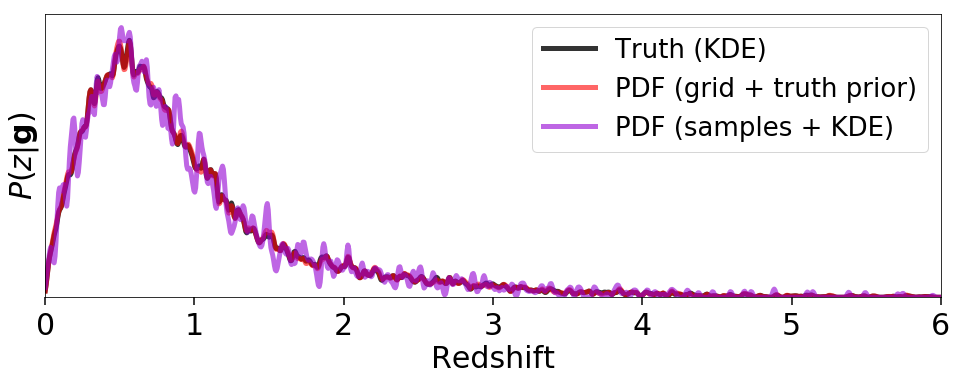

In [13]:
# plotting
plt.figure(figsize=(14, 6))
plt.plot(zgrid, pdf, lw=5, color='black', alpha=0.8,
         label='Truth (KDE)')
plt.plot(zgrid, znew.sum(axis=0) / Nobs, lw=5, color='red',
         alpha=0.6, label='PDF (grid + truth prior)')
plt.plot(zgrid, pdftrain, lw=5, color='darkviolet', alpha=0.6,
         label='PDF (samples + KDE)')
plt.xlabel('Redshift')
plt.xlim([zbins[0], zbins[-1]])
plt.yticks([])
plt.ylim([0., None])
plt.ylabel('$P(z|\mathbf{g})$')
plt.legend(fontsize=26, loc='best')
plt.tight_layout()

While this estimate is accurate overall, it's subject to a some additional noise due to sampling variance. As a result, it relies on there being a *lot* of samples available for estimation, especially if we want to probe the tails of the redshift distribution.

## Noisy Samples

Finally, we consider the case where our samples/training data are *also* noisy redshift estimates characterized by a redshift PDF $P(z|h) \neq \delta(z_h - z)$. If we take these to also be Gaussian kernels with $\mathcal{N}(z|\mu=\hat{z}_h, \sigma=\hat{\sigma}_h)$, we get

$$
P(h|g) = \frac{P(h,g)}{P(g)} = \frac{\int P(g|z) P(z|h) P(h) dz}{\sum_{h \in \mathbf{h}} \int P(g|z) P(z|h) P(h) dz} = \frac{\mathcal{N}(\hat{z}_g|\mu=z_h,\sigma^2=\hat{\sigma}_g^2+\hat{\sigma}_h^2)}{\sum_{h \in \mathbf{h}} \mathcal{N}(\hat{z}_g|\mu=z_h,\sigma^2=\hat{\sigma}_g^2+\hat{\sigma}_h^2)} 
$$

In [14]:
# generate PDFs
sigma_train = np.random.uniform(0.01, 0.1, size=Ntrain)  # width
mu_train = np.random.normal(ztrain, sigma_train)  # mean

In [15]:
# stack results
ztrain_wt2 = np.zeros(Ntrain)
evid_obs2 = np.zeros(Nobs)
chi2_obs2 = np.zeros(Nobs)
for i in range(Nobs):
    if i % 1000 == 0:
        sys.stderr.write('{0} '.format(i))
    wt = frankenz.pdf.gaussian(mu_train, 
                               np.sqrt(sigma[i]**2 + sigma_train**2),
                               mu[i])
    chi2_obs2[i] = min((mu_train - mu[i])**2 / (sigma[i]**2 + sigma_train**2))
    evid_obs2[i] = sum(wt) * Nobs
    ztrain_wt2 += wt / evid_obs2[i]

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 

We now stack the corresponding kernels.

In [16]:
# KDE
pdftrain2 = frankenz.pdf.gauss_kde(mu_train, sigma_train, zgrid, y_wt=ztrain_wt2)
pdftrain2 /= np.trapz(pdftrain2, zgrid)

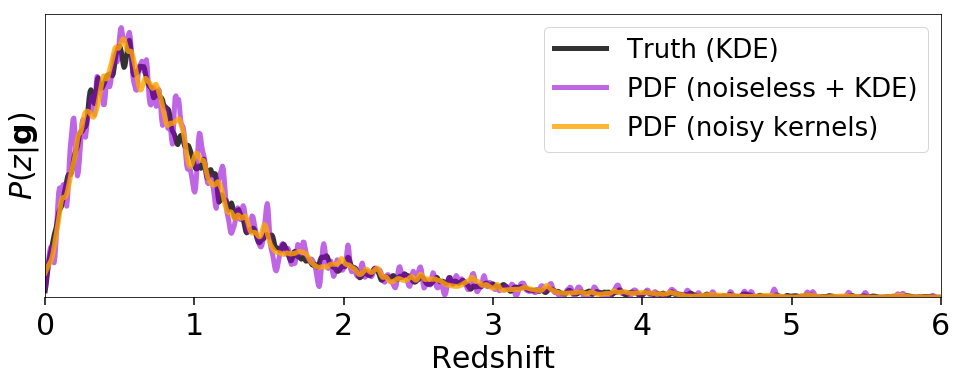

In [17]:
# plotting
plt.figure(figsize=(14, 6))
plt.plot(zgrid, pdf, lw=5, color='black', alpha=0.8,
         label='Truth (KDE)')
plt.plot(zgrid, pdftrain, lw=5, color='darkviolet', alpha=0.6,
         label=r'PDF (noiseless + KDE)')
plt.plot(zgrid, pdftrain2, lw=5, color='orange', alpha=0.8,
         label=r'PDF (noisy kernels)')
plt.xlabel('Redshift')
plt.xlim([zbins[0], zbins[-1]])
plt.yticks([])
plt.ylim([0., None])
plt.ylabel('$P(z|\mathbf{g})$')
plt.legend(fontsize=26, loc='best')
plt.tight_layout()

By eye, it appears that our PDF using the same number of "noisy" samples is actually a better representation of  our PDF using noiseless samples. What gives?

There are three reasons for this:
1. It makes a difference whether a probabilistic basis is incorporated directly into the likelihoods or implemented afterwards. In the noiseless case, we applied KDE afterwards rather than assigning each object its own kernel when deriving our likelihoods, which ignores the intrinsic width of the kernel.
2. The smoothing scale for our inference is set by the width of our kernels. In the noiseless case, we chose the same smoothing scale ($\Delta z = 0.01$) used for our grid, while for the noisy case our smoothing scale varies from $\Delta z = 0.01 - 0.1$. This sets the scale for variation, and since the total number of samples we are using is relatively small, we would expect a broader smoothing scale to give better results in general.
3. While each individual PDF from our noisy sample is a noisy draw from the underlying density, across the ensemble the noise generally averages out, giving an unbaised representation of the true underlying distribution.

Just to demonstrate the impact of these effects, we repeat the above analysis using our noiseless kernels to re-derive our original noiseless $N(z|\mathbf{g})$ below.

In [18]:
# stack results
ztrain_wt3 = np.zeros(Ntrain)
evid_obs3 = np.zeros(Nobs)
chi2_obs3 = np.zeros(Nobs)
for i in range(Nobs):
    if i % 1000 == 0:
        sys.stderr.write('{0} '.format(i))
    wt = frankenz.pdf.gaussian(ztrain, 
                               np.sqrt(sigma[i]**2 + sigma_train**2),
                               mu[i])
    chi2_obs3 = min((ztrain - mu[i])**2 / (sigma[i]**2 + sigma_train**2))
    evid_obs3[i] = sum(wt) * Nobs
    ztrain_wt3 += wt / evid_obs3[i]

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 

In [19]:
# KDE
pdftrain3 = frankenz.pdf.gauss_kde(ztrain, np.ones(Ntrain) * 0.05, zgrid, y_wt=ztrain_wt3)
pdftrain3 /= np.trapz(pdftrain3, zgrid)

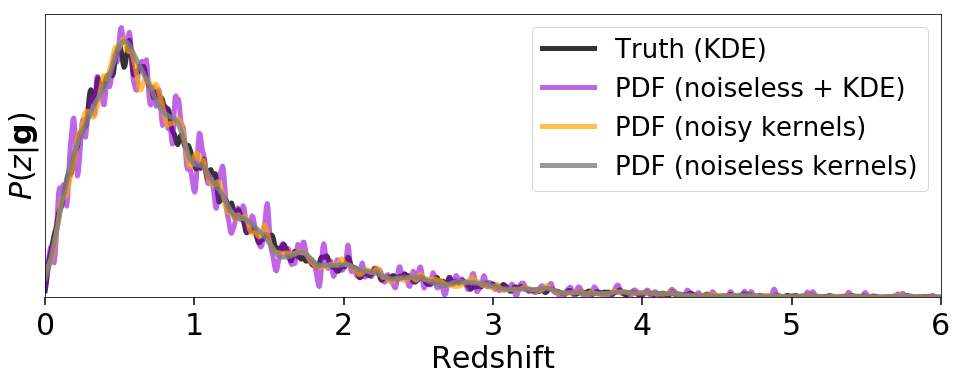

In [20]:
# plotting
plt.figure(figsize=(14, 6))
plt.plot(zgrid, pdf, lw=5, color='black', alpha=0.8,
         label='Truth (KDE)')
plt.plot(zgrid, pdftrain, lw=5, color='darkviolet', alpha=0.6,
         label=r'PDF (noiseless + KDE)')
plt.plot(zgrid, pdftrain2, lw=5, color='orange', alpha=0.7,
         label=r'PDF (noisy kernels)')
plt.plot(zgrid, pdftrain3, lw=5, color='gray', alpha=0.8,
         label=r'PDF (noiseless kernels)')
plt.xlabel('Redshift')
plt.xlim([zbins[0], zbins[-1]])
plt.yticks([])
plt.ylim([0., None])
plt.ylabel('$P(z|\mathbf{g})$')
plt.legend(fontsize=26, loc='best')
plt.tight_layout()

As expected, our noiseless kernels are somewhat better than our noisy kernels, both of which are more accurate that our noiseless results (which is more sensitive to sample variance).

## Sidenote: Coverage

One of the risks that becomes immediately apparent moving from grids to samples is the issue of **coverage**. In other words, our training data may not adequately cover all of the parameter space spanned by our observable PDFs.

We can diagnose this a variety of different ways, but we'll just briefly discuss two quantities: the **evidence** $P(g)$ and the best-fit $\chi^2_\min(g)$ value. The former tells us how much "overlap" our object has with the training set (basis), modulo normalizations. The latter tells us how "close" our object gets to a member of our training set.

We see that while the two quantities are correlated, they contain different information. Applying appropriate cuts in this plane can help "prune" objects whose predictions are untrustworthy.

# Population Modeling

We now want to derive *errors* around our $N(z|\mathbf{g})$ predictions from our underlying PDFs. In particular, we want to generate a series of posterior $N(z|\mathbf{g})$ samples.

To start, we're going to go back to our model grid over our point process since inference is more intuitive in that domain.

In [21]:
# number of samples
Nsamples = 50

## Poisson Approximation

A common approximation is that the number of objects in each redshift bin are independent of each other and simply a counting (Poisson) process. The number of objects in each bin then follows a **Poisson distribution**

$$
\hat{N}_h \sim \textrm{Pois}(N|\lambda = N(z_h|\mathbf{g}))
$$

where $\lambda$ is the associated concentration parameter.

In [22]:
# draw Poisson samples
pdf1 = zpdf.sum(axis=0)  # stacked PDFs
pdf1 /= pdf1.sum()  # normalize
pdf1 *= Nobs  # sample size
pdf1_samples = np.array([np.random.poisson(pdf1) 
                         for i in xrange(Nsamples)])  # draw samples

The Poisson approximation implies that the number of objects we observe at a given redshift is simply a counting process with mean $\mu = \lambda = N(z_h|\mathbf{g})$. This isn't quite right, since this assumes the number of objects observed at different $z_h$'s are independent, when we know that there must be *some* covariance due to each object's redshift PDF. More importantly, however, this approximation implies that the total number of objects we observe doesn't remain constant!

That said, let's see how our results look.

In [23]:
def zplot(samples, label='type', color='blue'):
    """Plot our draws."""
    
    [plt.plot(zgrid, samples[i], lw=2, color=color, alpha=0.02)
     for i in xrange(Nsamples)]
    plt.plot(zgrid, pdf/pdf.sum() * Nobs, lw=5, color='black',
             alpha=0.7)
    plt.plot(zgrid, pdf * 0.0 - 1e4, lw=3, color=color,
             alpha=0.5, label=label)
    plt.xlabel('Redshift')
    plt.xlim([zgrid[0], zgrid[-1]])
    plt.yticks([])
    plt.ylim([0, max(pdf / pdf.sum() * Nobs) * 1.2])
    plt.ylabel('$N(z|\mathbf{g})$')
    plt.legend(fontsize=26, loc='best')
    plt.tight_layout()

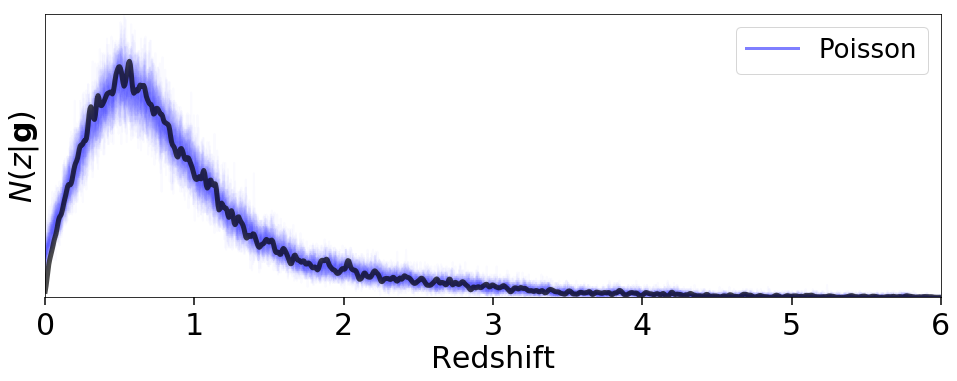

In [24]:
# plotting
plt.figure(figsize=(14, 6))
zplot(pdf1_samples, label='Poisson', color='blue')

Given our previous concerns, that looks reasonable overall.

## Multinomial Approximation

One improvement on the Poisson is to assume our observed $N(\mathbf{z}|\mathbf{g})$ is drawn from the **Multinomial distribution**. Defining 

$$ \mathbf{p_h}(\mathbf{g}) = \lbrace \dots, P(z_h|\mathbf{g}), \dots \rbrace $$
$$ \mathbf{n_h} = \lbrace \dots, \hat{N}_h(\mathbf{g}), \dots \rbrace$$

our model then is

$$
\mathbf{n_h} \sim \textrm{Mult}\left(n = N_g, \mathbf{p} = \mathbf{p_h}(\mathbf{g})\right)
$$

where $n$ is the number of draws and $\mathbf{p}$ is the probability of associated with our $N_h$ categories (in this case our redshift grid points).

In [25]:
# draw multinomial samples
pdf2_samples = np.random.multinomial(Nobs, pdf1 / pdf1.sum(),
                                     size=Nsamples)  # samples

What's the intuition for this form? This implies that the PDF of a random observed galaxy $g$ is proportional to the observed $P(z|\mathbf{g})$. The Multinomial has the benefit of keeping the overall number of galaxies constant, and in doing so induces correlations among the individual categories (redshift points). However, given the fact that galaxies don't all have the same PDF, the correlations this will induce among our redshift bins will likely be off.

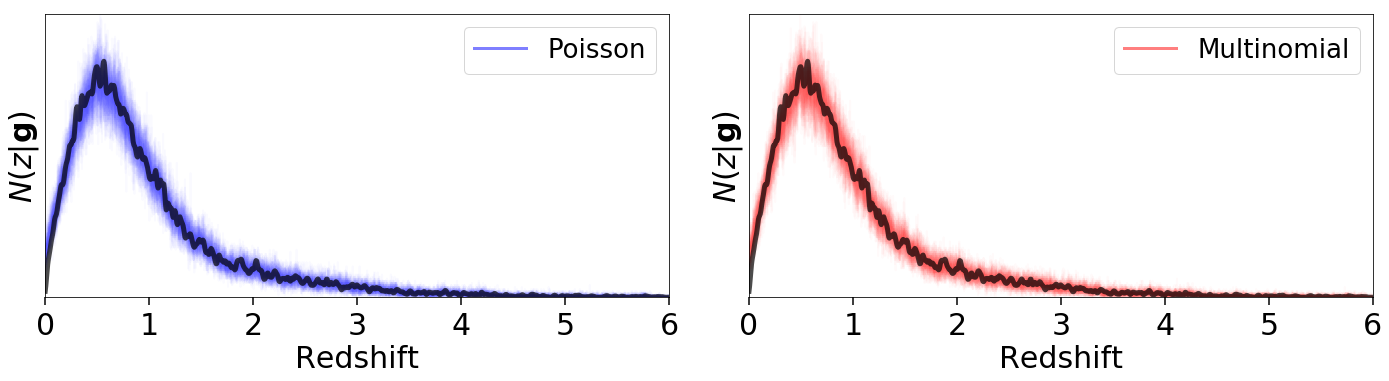

In [26]:
# plotting
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
zplot(pdf1_samples, label='Poisson', color='blue')
plt.subplot(1, 2, 2)
zplot(pdf2_samples, label='Multinomial', color='red')

## Posterior Samples

Any particular galaxy $g$ with PDF $\mathbf{p}_g = \lbrace \dots, P(z_h|g), \dots \rbrace$ is fundamentally located at a particular redshift $z_g$ -- the corresponding redshift PDF simply illustrates our uncertainty over its true location. We can treat $z_g$ as a **random variable** which is distributed as

$$
z_g \sim \textrm{Cat}(\mathbf{p}=\mathbf{p}_g) = \textrm{Mult} \left(n=1, \mathbf{p}=\mathbf{p}_g \right)
$$

over our redshift bins $\mathbf{z_h} = \lbrace \dots, z_h, \dots \rbrace$. The redshift number density is then

$$
\mathbf{n_h} \sim \sum_{g \in \mathbf{g}} \textrm{Cat} \left(\mathbf{p}=\mathbf{p}_g \right)
$$

This represents a convolution of a series of Multinomial-distributed random variables with different PDFs. While this doesn't have a simple closed-form solution, it is straightforward to draw samples $\mathbf{n_h}^{(i)}$ from this distribution by iteratively drawing redshifts from the underlying PDFs and then stacking the results.

In [27]:
# draw posterior samples
pdf3_samples = np.zeros_like(pdf1_samples)
for j in range(Nsamples):
    sys.stderr.write(' {0}'.format(j))
    for i in range(Nobs):
        # stack categorial draw
        pdf3_samples[j] += np.random.multinomial(1, zpdf[i] / zpdf[i].sum())

 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49

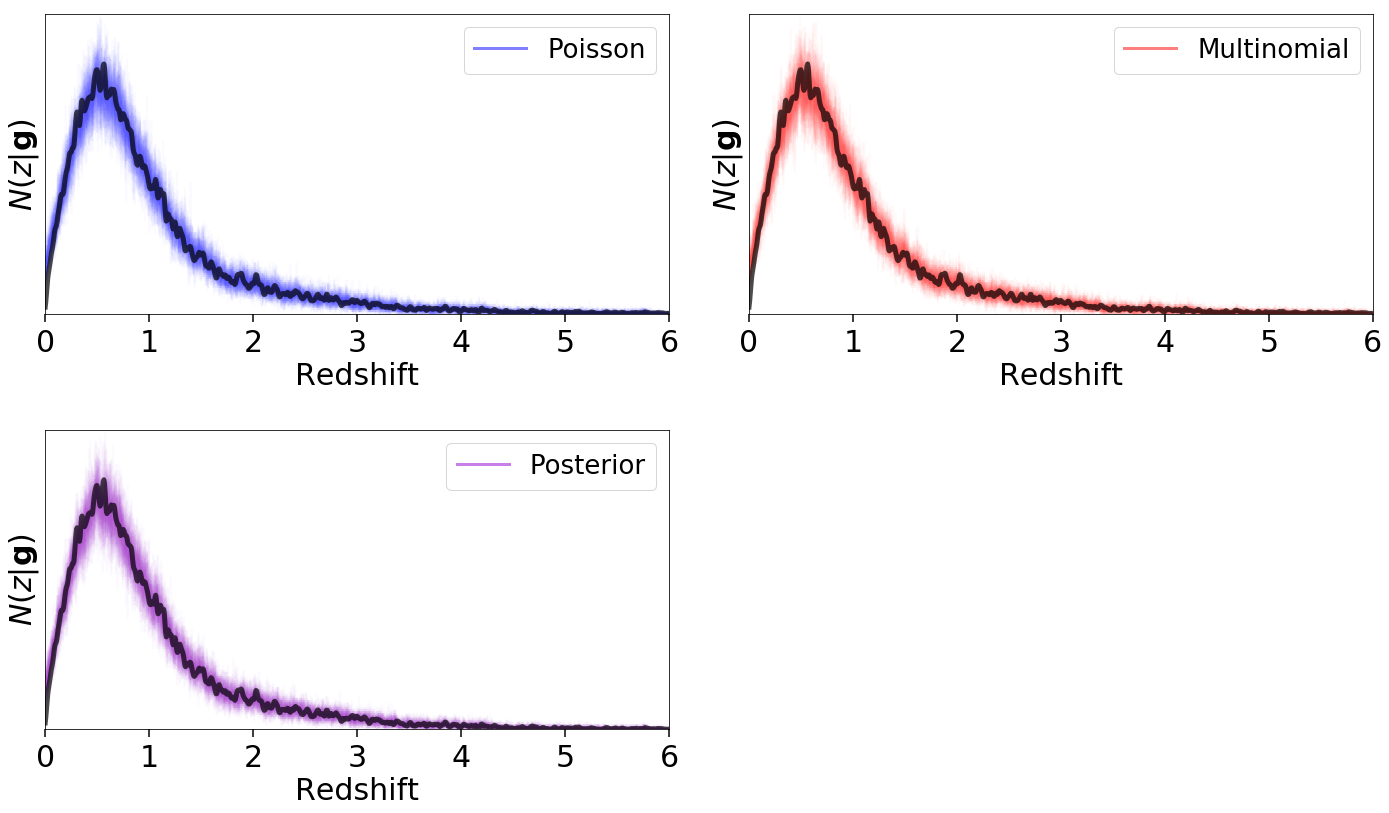

In [28]:
# plotting
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
zplot(pdf1_samples, label='Poisson', color='blue')
plt.subplot(2, 2, 2)
zplot(pdf2_samples, label='Multinomial', color='red')
plt.subplot(2, 2, 3)
zplot(pdf3_samples, label='Posterior', color='darkviolet')

# Hierarchical Bayesian Modeling

Given a probability vector $\mathbf{p}_g$, an individual galaxy's redshift $z_g$ is distributed as $z_g \sim \textrm{Cat}\left(\mathbf{p}_g\right)$. However, given a dataset with $N_g$ objects with corresponding number densities $\mathbf{n}$ across our $N_h$ categories that we use to estimate $\mathbf{p_h}$, our probability vector $\mathbf{p_h}$ is distributed as

$$ 
\mathbf{p_h} \sim \textrm{Dir}\left(\mathbf{p_h} | \boldsymbol{\alpha} = \mathbf{n_h} + 1 \right)
$$

where $\textrm{Dir}\left(\mathbf{p}|\boldsymbol{\alpha}\right)$ is the **Dirichlet distribution** with concentration parameter $\boldsymbol{\alpha}$ across our $N_h$ categories. In general, this tends to upweight our tails and downweight the peak.

We now define a set of redshift **population weights** $\mathbf{w_h}$ corresponding to our redshift bins $\mathbf{z_h}$ whose posterior distribution is

$$
\mathbf{w_h} \sim \textrm{Dir}\left(\mathbf{w_h} | \boldsymbol{\alpha} = \mathbf{n_h}+1 \right), 
\quad 
\mathbf{n_h} \sim \sum_{g \in \mathbf{g}} \textrm{Cat} \left(\mathbf{p}=\mathbf{p}_g \right) \quad .
$$

These weights essentially serve as a type of population-driven prior over our data (which we've previous assume has been fixed). Since we don't know what these are *a priori*, we want to sample them jointly along with our observed number densities. In other words, rather than sampling from $P(\mathbf{w_h}|\lbrace \dots, \mathbf{p}_g, \dots \rbrace)$, we want to sample from the **joint distribution** $P(\mathbf{w_h}, \lbrace \dots, \mathbf{p}_g, \dots \rbrace)$, where $\mathbf{w_h}$ depends on our $\mathbf{p}_g$'s through $\mathbf{n_h}$.

## Sampling the Joint Distribution

How do we sample from such a distribution? In general, our model is intractable for typical **Markov Chain Monte Carlo (MCMC)** rejection samplers that try and probe the $(N_h + N_g)$-parameter joint distribution directly using, e.g., **Metropolis proposals**. 

It is, however, particularly amenable to **Gibbs sampling**, which samples from joint distribution by iteratively sampling from the associated conditional distributions. In this case, this means we sample iteratively from $P(\lbrace \dots, \mathbf{p}_g, \dots \rbrace | \mathbf{w_h})$ and $P(\mathbf{w_h} | \lbrace \dots, \mathbf{p}_g, \dots \rbrace)$. Assuming **Poisson independence** for all $g \in \mathbf{g}$, we can draw our samples from our joint posterior via

\begin{align}
\textrm{Sample individual redshifts:}& \quad \lbrace \dots, \mathbf{\hat{p}}_g^{(i)}, \dots \rbrace \sim \left\lbrace \dots, \textrm{Cat}\left( \mathbf{p}=\mathbf{p}_g \bullet \mathbf{w_h}^{(i-1)} \right), \dots \right\rbrace \\
\textrm{Compute number density:}& \quad \mathbf{n_h}^{(i)} = \sum_{g \in \mathbf{g}} \mathbf{\hat{p}}_g^{(i)} \\
\textrm{Sample population weights:}& \quad \mathbf{w_h}^{(i)} \sim \textrm{Dir}\left(\mathbf{w_h} | \mathbf{n_h}^{(i)} + 1\right) \quad ,
\end{align}

where $\bullet$ indicates the **Hadamard product** (i.e. element-wise multiplication) and $\mathbf{\hat{p}}_g$ is the sampled probability vector which is $1$ where $z_h=\hat{z}_g$ and $0$ elsewhere.

As with any MCMC sampler, we need time to "burn in" to the stationary distribution and often some subsequent thinning of the to ensure (relatively more) independent samples. We check both of these conditions below by looking at the autocorrelation time for a few of our redshift grid points and the general autocorrelation for $\Delta t=1$.

In [29]:
# sample from our hierarchical model
Nburn = 0  # burnin
Nthin = 5  # thinning
pdf4_samples_w = np.zeros_like(pdf1_samples)
pdf4_samples_n = np.zeros_like(pdf1_samples)

wt = np.ones_like(zgrid) # initialize weights
for j in xrange(Nthin * (Nsamples + Nburn)):
    count = int(j / Nthin) - Nburn
    if (j + 1) % Nthin == 0: 
        sys.stderr.write('{0} '.format(count))
        
    # Compute new posterior.
    pstack = np.zeros_like(zgrid)
    zpdf_t = zpdf * wt
    zpdf_t /= zpdf_t.sum(axis=1)[:, None]
    
    # Stack posterior.
    for i in range(Nobs):
        pstack += np.random.multinomial(1, zpdf_t[i])
        
    # Sample population weights.
    wt = np.random.dirichlet(pstack + 1.) * Nobs
        
    # Save samples.
    if (j + 1) % Nthin == 0 and count >= 0:
        pdf4_samples_n[count] = pstack.copy()
        pdf4_samples_w[count] = wt.copy()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

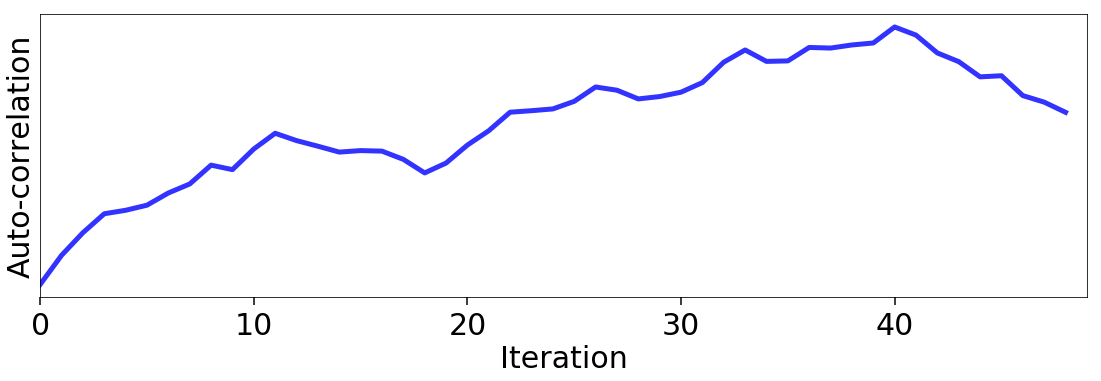

In [30]:
# plot lag=1 autocorrelation
plt.figure(figsize=(16, 6))
autocorr = np.array([np.correlate(pdf4_samples_n[i], pdf4_samples_n[i+1])
                     for i in range(Nsamples - 1)]).flatten()
plt.plot(autocorr, lw=5, color='blue', alpha=0.8)
plt.xlabel('Iteration')
plt.xlim([0., Nsamples - 1])
plt.yticks([])
plt.ylabel('Auto-correlation')
plt.tight_layout()

It seems we've approximately burned in after ~20 samples (i.e. 100 raw samples).

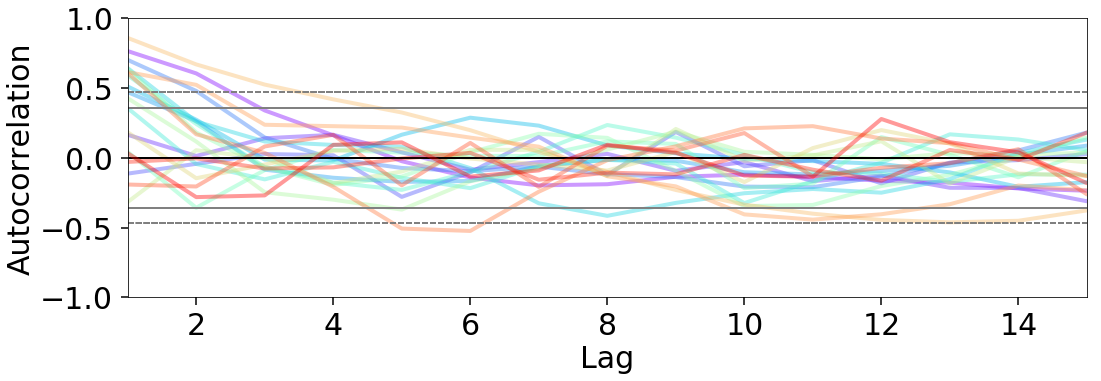

In [31]:
from pandas.plotting import autocorrelation_plot

# plot autocorrelation lag
Nburnin = 20
Nplot = 20
plt.figure(figsize=(16, 6))
colors = plt.get_cmap('rainbow')(np.linspace(0., 1., Nplot))
idxs = np.random.choice(len(zgrid), size=Nplot, replace=False)
[autocorrelation_plot(pdf4_samples_n[Nburnin:, i], 
                      color=c, lw=4, alpha=0.4) 
 for i, c in zip(idxs, colors)]
plt.xlim([1, (Nsamples - Nburnin) / 2])
plt.tight_layout()

While most of our samples are uncorrelated, a few have longer autocorrelation lengths. We'll pick 20 (raw) samples as a reasonable choice.

In [32]:
# sample from our hierarchical model
Nburn = 10  # burnin
Nthin = 20  # thinning
pdf4_samples_w = np.zeros_like(pdf1_samples)
pdf4_samples_n = np.zeros_like(pdf1_samples)

wt = np.ones_like(zgrid) # initialize weights
for j in xrange(Nthin * (Nsamples + Nburn)):
    count = int(j / Nthin) - Nburn
    if (j + 1) % Nthin == 0: 
        sys.stderr.write('{0} '.format(count))
        
    # Compute new posterior.
    pstack = np.zeros_like(zgrid)
    zpdf_t = zpdf * wt
    zpdf_t /= zpdf_t.sum(axis=1)[:, None]
    
    # Stack posterior.
    for i in range(Nobs):
        pstack += np.random.multinomial(1, zpdf_t[i])
        
    # Sample population weights.
    wt = np.random.dirichlet(pstack + 1.) * Nobs
        
    # Save samples.
    if (j + 1) % Nthin == 0 and count >= 0:
        pdf4_samples_n[count] = pstack.copy()
        pdf4_samples_w[count] = wt.copy()

-10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

Now let's take a look at our final results.

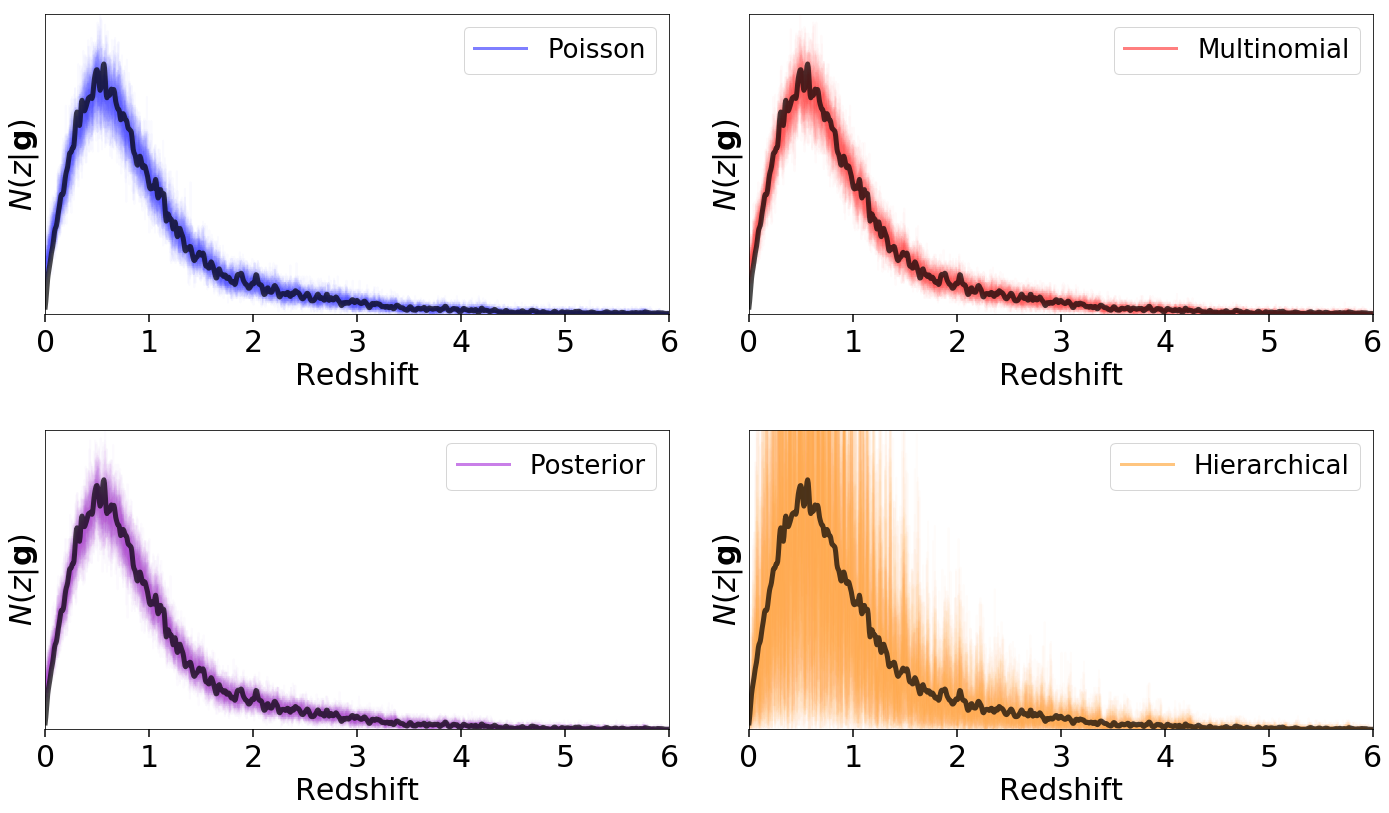

In [33]:
# plotting
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
zplot(pdf1_samples, label='Poisson', color='blue')
plt.subplot(2, 2, 2)
zplot(pdf2_samples, label='Multinomial', color='red')
plt.subplot(2, 2, 3)
zplot(pdf3_samples, label='Posterior', color='darkviolet')
plt.subplot(2, 2, 4)
zplot(pdf4_samples_n, label='Hierarchical', color='darkorange')

Our hierarchical sample appears to experience some enourmous variation! There are a few primary reasons for this. Most crucially, our Dirichlet distribution is fundamentally an unordered distribution over our grid. By disregarding the fact that the amplitude of nearby redshift bins should inherently be strongly correlated with each other, it allows for more (unphysical) variation than might otherwise be possible. In addition, our PDFs are relatively broad compared to the resolution of our redshift grid (encompassing 2-20 bins out of 601), especially given the size of our sample (100k galaxies). This lends itself to a lot of possible sample variation since the total "number" of galaxies occupying a given redshift is (relatively) low.

These very noisy results, however, still can be leveraged to give good predictions at coarser resolutions, as shown below.

In [34]:
def zplot_bin(samples, label='type', color='blue', binning=5):
    """Plot our binned draws."""
    [plt.hist(zgrid, zgrid[::binning], weights=samples[i], lw=3,
              histtype='step', color=color, alpha=0.1) 
     for i in xrange(Nsamples)]
    plt.hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step',
             color=color, alpha=0.6, label=label)
    h = plt.hist(zgrid, zgrid[::binning], weights = pdf/pdf.sum() * Nobs,
                 histtype='step', lw=6, color='black', alpha=0.6)
    plt.xlabel('Redshift')
    plt.xlim([zgrid[0], zgrid[-1]])
    plt.yticks([])
    plt.ylim([0, max(h[0]) * 1.2])
    plt.ylabel('$N(z|\mathbf{g})$')
    plt.legend(fontsize=26, loc='best')
    plt.tight_layout()

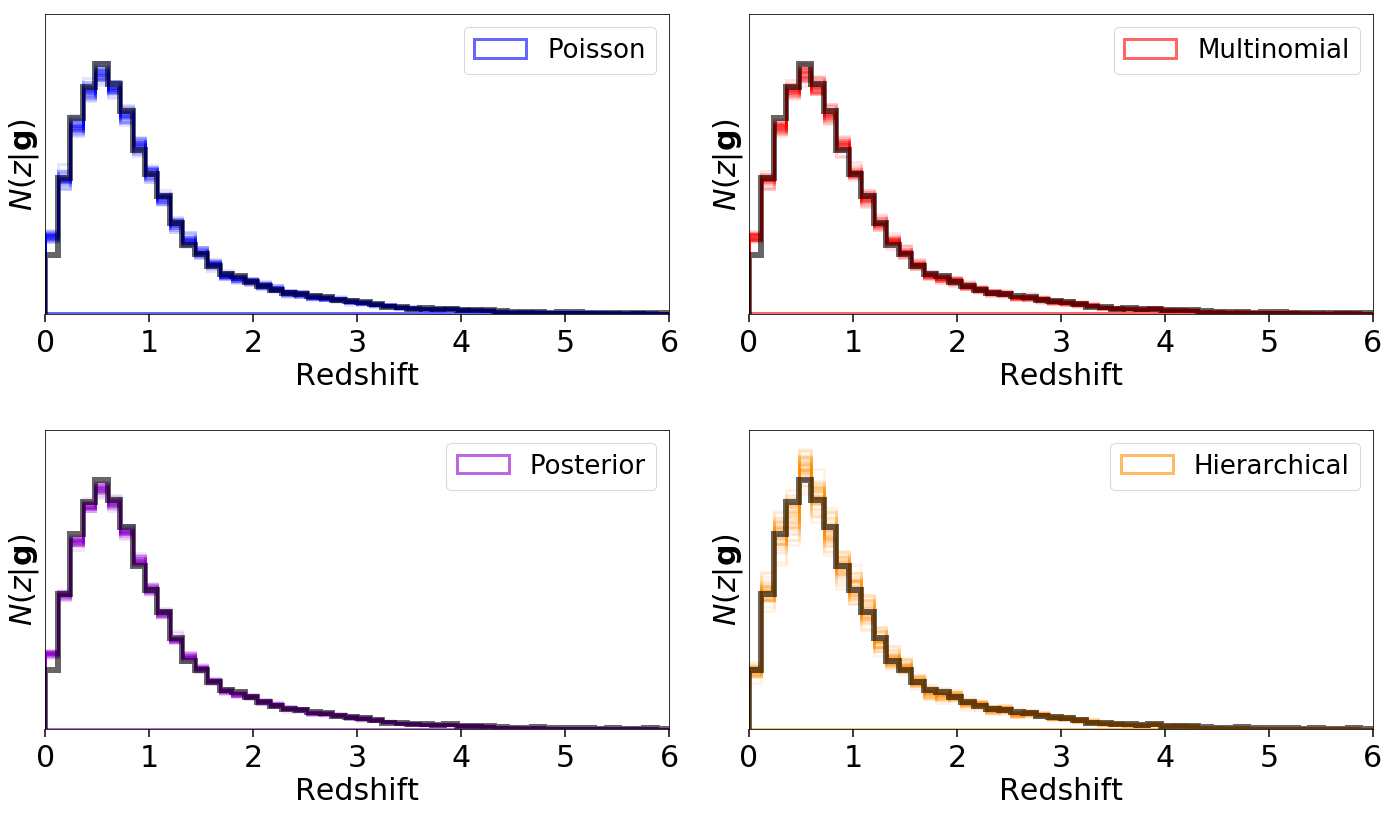

In [35]:
# plotting binned results
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
zplot_bin(pdf1_samples, label='Poisson', color='blue', binning=20)
plt.subplot(2, 2, 2)
zplot_bin(pdf2_samples, label='Multinomial', color='red', binning=20)
plt.subplot(2, 2, 3)
zplot_bin(pdf3_samples, label='Posterior', color='darkviolet', binning=20)
plt.subplot(2, 2, 4)
zplot_bin(pdf4_samples_n, label='Hierarchical', color='darkorange', binning=20)

Only our hierarchical model is able to properly recover the true underlying distribution at the low redshift end.

Another way to visualize our results is by looking at the covariances between neighboring redshift bins. We'll just take a look at one here.

In [36]:
def cov_draws(samples, bin1=(60, 80), bin2=(80, 100), color='blue', label='label'):
    """Plot our draws within two bins."""

    # Bin results.
    pdf_bin1 = pdf[bin1[0]:bin1[1]].sum() / pdf.sum() * Nobs / 1e3
    pdf_bin2 = pdf[bin2[0]:bin2[1]].sum() / pdf.sum() * Nobs / 1e3
    samples_bin1 = samples[:, bin1[0]:bin1[1]].sum(axis=1) / 1e3
    samples_bin2 = samples[:, bin2[0]:bin2[1]].sum(axis=1) / 1e3
    
    # Plot results.
    plt.vlines(pdf_bin1, 0, 100, lw=2, colors='black', linestyles='--')
    plt.hlines(pdf_bin2, 0, 100, lw=2, colors='black', linestyles='--')
    plt.plot(pdf_bin1, pdf_bin2, 's', color='black', markersize=20)
    plt.plot(samples_bin1, samples_bin2, 'o', color=color, 
             label=label, markersize=15, alpha=0.6)
    plt.xlim([min(samples_bin1) - 0.1, max(samples_bin1) + 0.1])
    plt.ylim([min(samples_bin2) - 0.1, max(samples_bin2) + 0.1])
    plt.xlabel(r'$N({0}\leq z < {1}) \quad [10^3]$'.format(zgrid[bin1[0]], zgrid[bin1[1]]))
    plt.ylabel(r'$N({0}\leq z < {1}) \quad [10^3]$'.format(zgrid[bin2[0]], zgrid[bin2[1]]))
    plt.legend(fontsize=28, loc=1)
    plt.tight_layout()

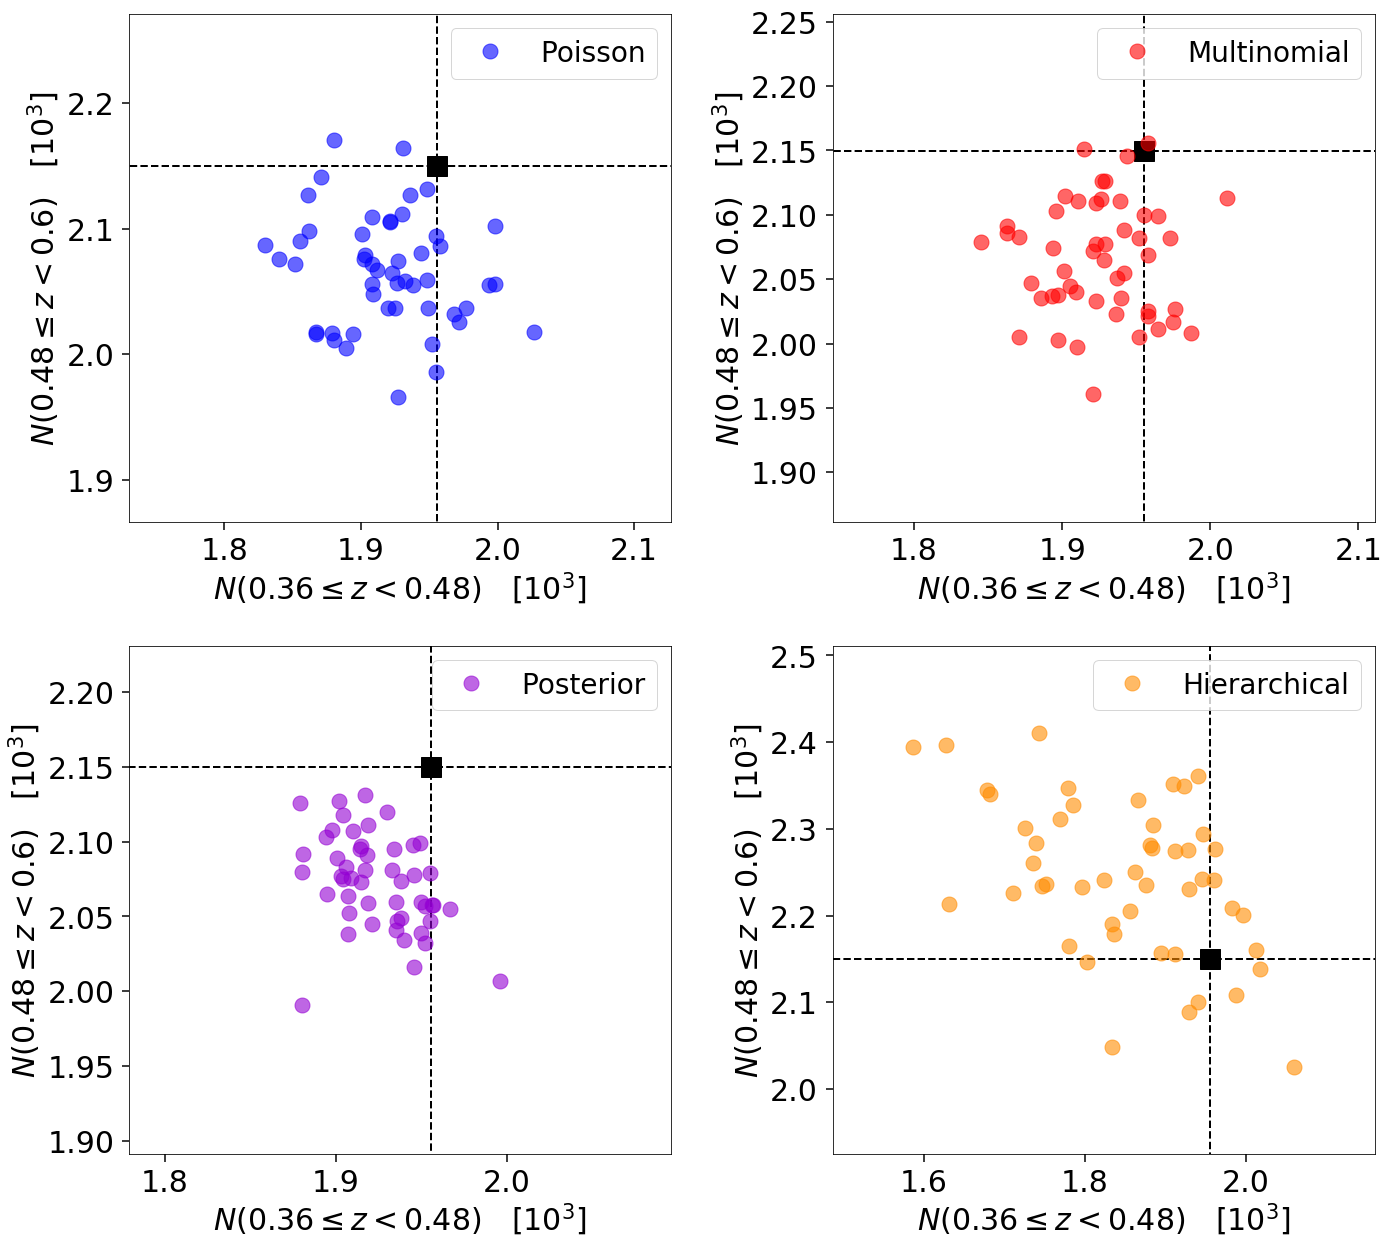

In [37]:
plt.figure(figsize=(20,18))
plt.subplot(2,2,1)
cov_draws(pdf1_samples, bin1=(60, 80), bin2=(80, 100),
          color='blue', label='Poisson')
plt.subplot(2,2,2)
cov_draws(pdf2_samples, bin1=(60, 80), bin2=(80, 100),
          color='red', label='Multinomial')
plt.subplot(2,2,3)
cov_draws(pdf3_samples, bin1=(60, 80), bin2=(80, 100),
          color='darkviolet', label='Posterior')
plt.subplot(2,2,4)
cov_draws(pdf4_samples_n[1:], bin1=(60, 80), bin2=(80, 100),
          color='darkorange', label='Hierarchical')

Our behavior is as we expect: our Poisson model, which draws samples independently from the population, is not correlated. Our multinomial model is correlated but somewhat diffuse. Our posterior model is also correlated but more concentrated, since objects tend to have narrower PDFs as compared with the full sample. Finally, our hierarchical model is not only offset from our original predictions closer to the truth, but also shows the most variable behavior while retaining strong (anti-)correlations.

# Hierarchical Point Process

We now broaden our model to include an arbitrary basis of training objects with noisy redshift kernels. For simplicity, we use the same sample of training objects from earlier.

In [38]:
# compute posteriors
post = np.zeros((Nobs, Ntrain))
for i in range(Nobs):
    if i % 1000 == 0:
        sys.stderr.write('{0} '.format(i))
    wt = frankenz.pdf.gaussian(mu_train, 
                               np.sqrt(sigma[i]**2 + sigma_train**2),
                               mu[i])
    post[i] = wt / wt.sum()

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 

Since we now have likelihoods computed over a series of training objects using only our observables, we can now formulate our models directly in the **training data space**. After we draw our set of samples, it is then straightforward to **"map"** our results onto our target distribution of choice (in this case redshift).

In [39]:
# stack posteriors
pstack = post.sum(axis=0)

In [40]:
# Poisson
train1_samples = np.array([np.random.poisson(pstack) for i in range(Nsamples)])
z1_samples = np.zeros_like(pdf1_samples, dtype='float')
for i in range(Nsamples):
    sys.stderr.write('{0} '.format(i))
    
    # Draw redshift samples.
    zsamps = []
    for j in range(Ntrain):
        for k in range(train1_samples[i][j]):
            zsamps.append(np.random.normal(mu_train[j], sigma_train[j]))
    z1_samples[i] = frankenz.pdf.gauss_kde(zsamps, np.ones_like(zsamps) * 0.01,
                                           zgrid)  # KDE
    z1_samples[i] *= len(zsamps) / z1_samples[i].sum()  # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

In [41]:
# Multinomial
train2_samples = np.random.multinomial(Nobs, pstack / pstack.sum(),
                                       size=Nsamples)
z2_samples = np.zeros_like(z1_samples)
for i in range(Nsamples):
    sys.stderr.write('{0} '.format(i))
    zsamps = []
    for j in range(Ntrain):
        for k in range(train2_samples[i][j]):
            zsamps.append(np.random.normal(mu_train[j], sigma_train[j]))
    z2_samples[i] = frankenz.pdf.gauss_kde(zsamps, np.ones_like(zsamps) * 0.01,
                                           zgrid)  # KDE
    z2_samples[i] *= len(zsamps) / z2_samples[i].sum()  # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

In [42]:
# Posterior
train3_samples = np.zeros_like(train2_samples)
z3_samples = np.zeros_like(z2_samples)
for i in range(Nsamples):
    sys.stderr.write('{0} '.format(i))
    zsamps = []
    for j in range(Nobs):
        train3_samples[i] += np.random.multinomial(1, post[j])
    for j in range(Ntrain):
        for k in range(train3_samples[i][j]):
            zsamps.append(np.random.normal(mu_train[j], sigma_train[j]))
    z3_samples[i] = frankenz.pdf.gauss_kde(zsamps, np.ones_like(zsamps) * 0.01,
                                           zgrid)  # KDE
    z3_samples[i] *= len(zsamps) / z3_samples[i].sum()  # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

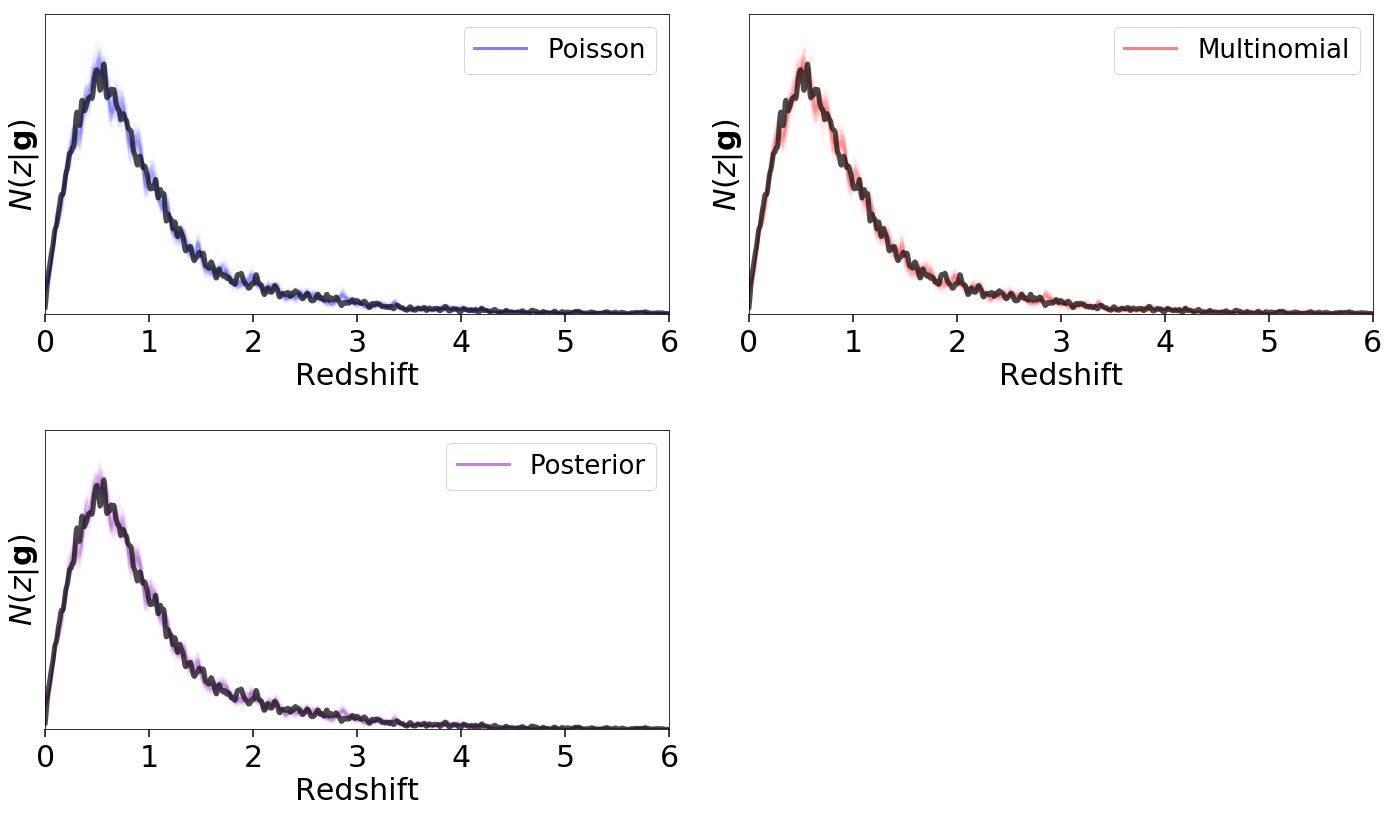

In [43]:
# plotting
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
zplot(z1_samples, label='Poisson', color='blue')
plt.subplot(2, 2, 2)
zplot(z2_samples, label='Multinomial', color='red')
plt.subplot(2, 2, 3)
zplot(z3_samples, label='Posterior', color='darkviolet')

While there is some variation between the draws in both the training object space and the target redshift space, in general our results here give consistent answers with each other up to the (intrinsic) noise introduced by the sampling density of our training set.

How does our hierarchical model do?

In [44]:
# sample from our hierarchical model
Nburn = 10  # burnin
Nthin = 20  # thinning
train4_samples_w = np.zeros_like(train2_samples)
train4_samples_n = np.zeros_like(train2_samples)

wt = np.ones_like(Ntrain) # initialize weights
for j in xrange(Nthin * (Nsamples + Nburn)):
    count = int(j / Nthin) - Nburn
    if (j + 1) % Nthin == 0: 
        sys.stderr.write('{0} '.format(count))
        
    # Compute new posterior.
    pstack_t = np.zeros(Ntrain)
    post_t = post * wt
    post_t /= post_t.sum(axis=1)[:, None]
    
    # Stack posterior.
    for i in range(Nobs):
        pstack_t += np.random.multinomial(1, post_t[i])
        
    # Sample population weights.
    wt = np.random.dirichlet(pstack_t + 1.) * Nobs
        
    # Save samples.
    if (j + 1) % Nthin == 0 and count >= 0:
        train4_samples_n[count] = pstack_t.copy()
        train4_samples_w[count] = wt.copy()

-10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

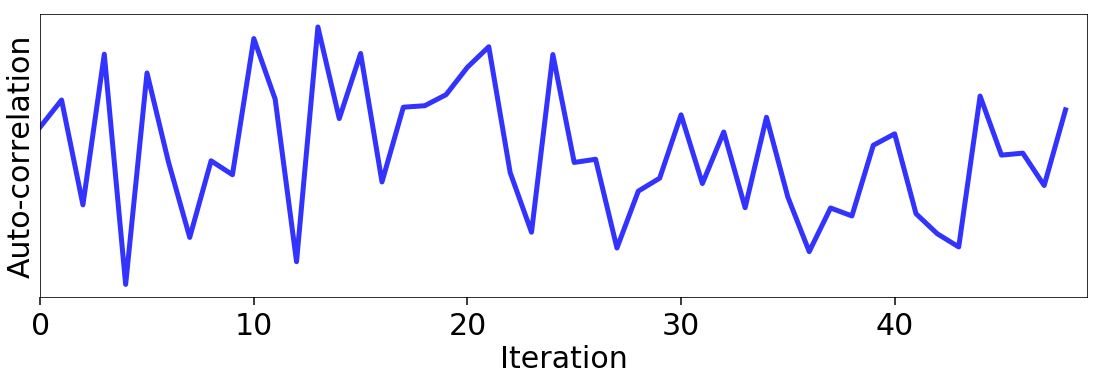

In [45]:
# plot lag=1 autocorrelation
plt.figure(figsize=(16, 6))
autocorr = np.array([np.correlate(train4_samples_n[i], train4_samples_n[i+1])
                     for i in range(Nsamples - 1)]).flatten()
plt.plot(autocorr, lw=5, color='blue', alpha=0.8)
plt.xlabel('Iteration')
plt.xlim([0., Nsamples - 1])
plt.yticks([])
plt.ylabel('Auto-correlation')
plt.tight_layout()

Now let's examine the traces of the training objects with the largest contributions to the redshift number density after burn-in.

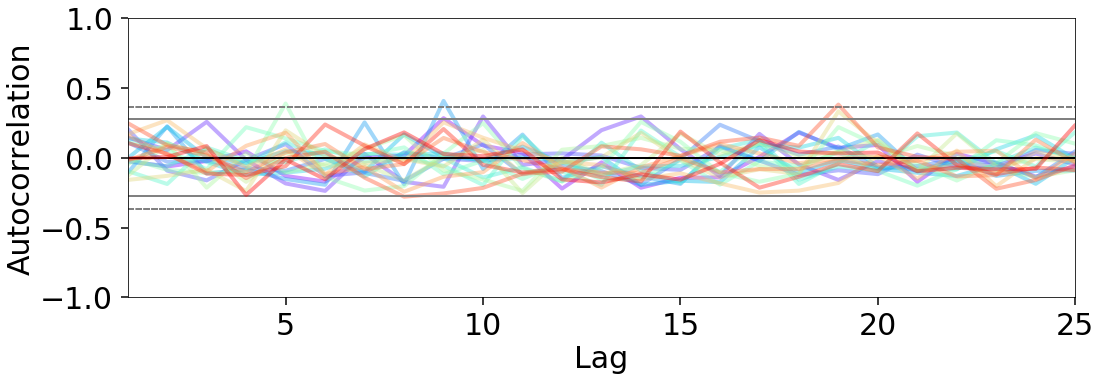

In [46]:
from pandas.plotting import autocorrelation_plot

# plot autocorrelation lag
Nburnin = 0
Nplot = 20
plt.figure(figsize=(16, 6))
colors = plt.get_cmap('rainbow')(np.linspace(0., 1., Nplot))
idxs = np.random.choice(len(zgrid), size=Nplot, replace=False)
[autocorrelation_plot(train4_samples_n[Nburnin:, i], 
                      color=c, lw=4, alpha=0.4) 
 for i, c in zip(idxs, colors)]
plt.xlim([1, (Nsamples - Nburnin) / 2])
plt.tight_layout()

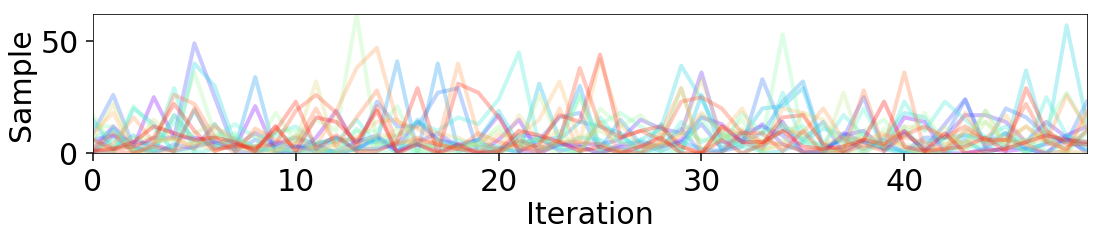

In [47]:
# plot samples
plt.figure(figsize=(16,4))
for i in range(Nplot):
    idx = idxs[i]
    plt.plot(train4_samples_n[:, idx], color=colors[i], lw=4, alpha=0.3)
plt.ylim([0., train4_samples_n[Nburnin:, idxs].max()])
plt.xlim([0, Nsamples - 1])
plt.xlabel('Iteration')
plt.ylabel('Sample')
plt.tight_layout()

While the mean for these objects can be significantly greater than 1, we also see that their number counts can change significantly. We now convert these draws into associated redshift distributions.

In [48]:
z4_samples = np.zeros_like(z3_samples)
for i in range(Nsamples):
    sys.stderr.write('{0} '.format(i))
    zsamps = []
    for j in range(Ntrain):
        for k in range(train4_samples_n[i][j]):
            zsamps.append(np.random.normal(mu_train[j], sigma_train[j]))
    z4_samples[i] = frankenz.pdf.gauss_kde(zsamps, np.ones_like(zsamps) * 0.01,
                                           zgrid)  # KDE
    z4_samples[i] *= len(zsamps) / z4_samples[i].sum()  # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

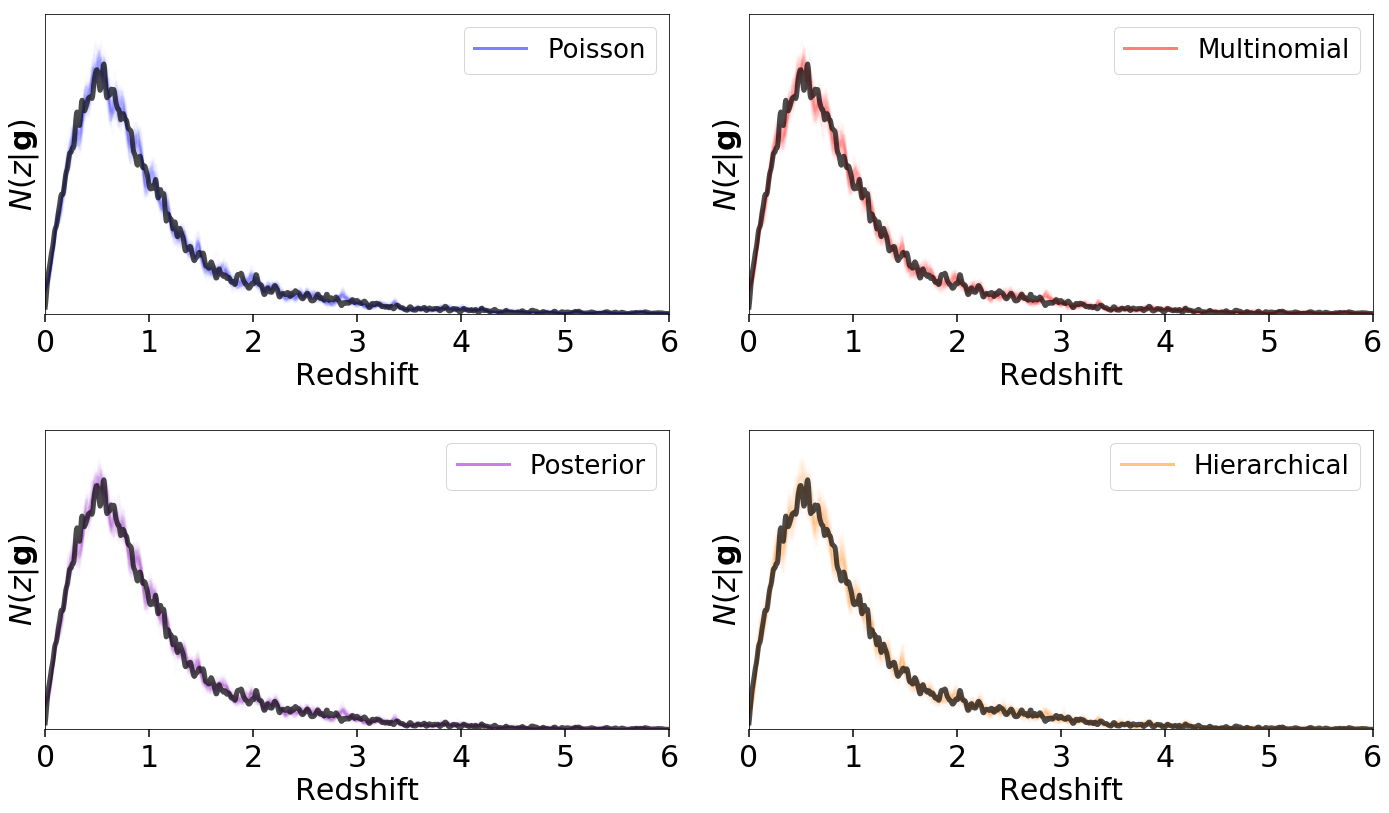

In [49]:
# plotting
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
zplot(z1_samples, label='Poisson', color='blue')
plt.subplot(2, 2, 2)
zplot(z2_samples, label='Multinomial', color='red')
plt.subplot(2, 2, 3)
zplot(z3_samples, label='Posterior', color='darkviolet')
plt.subplot(2, 2, 4)
zplot(z4_samples, label='Hierarchical', color='darkorange')

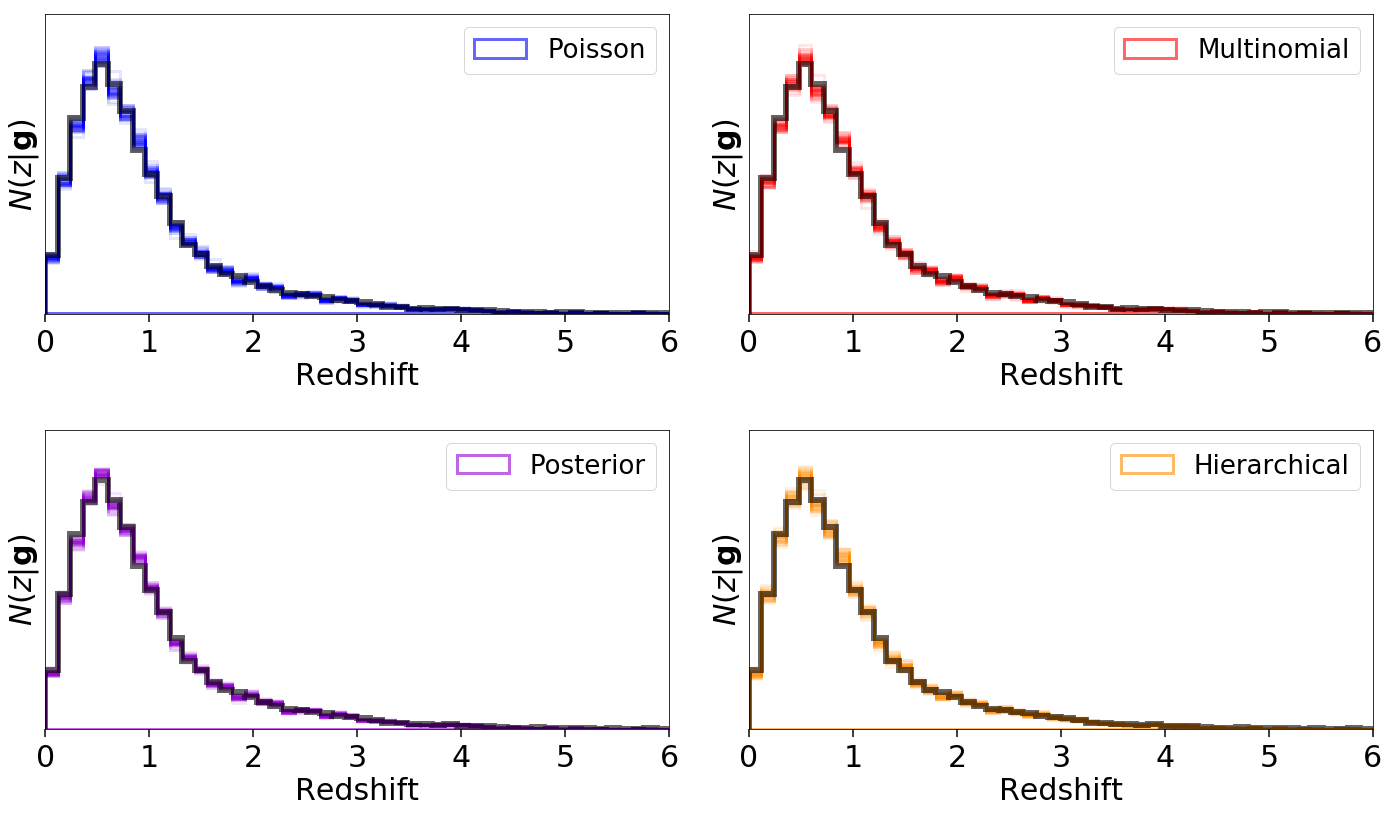

In [50]:
# plotting binned results
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
zplot_bin(z1_samples, label='Poisson', color='blue', binning=20)
plt.subplot(2, 2, 2)
zplot_bin(z2_samples, label='Multinomial', color='red', binning=20)
plt.subplot(2, 2, 3)
zplot_bin(z3_samples, label='Posterior', color='darkviolet', binning=20)
plt.subplot(2, 2, 4)
zplot_bin(z4_samples, label='Hierarchical', color='darkorange', binning=20)

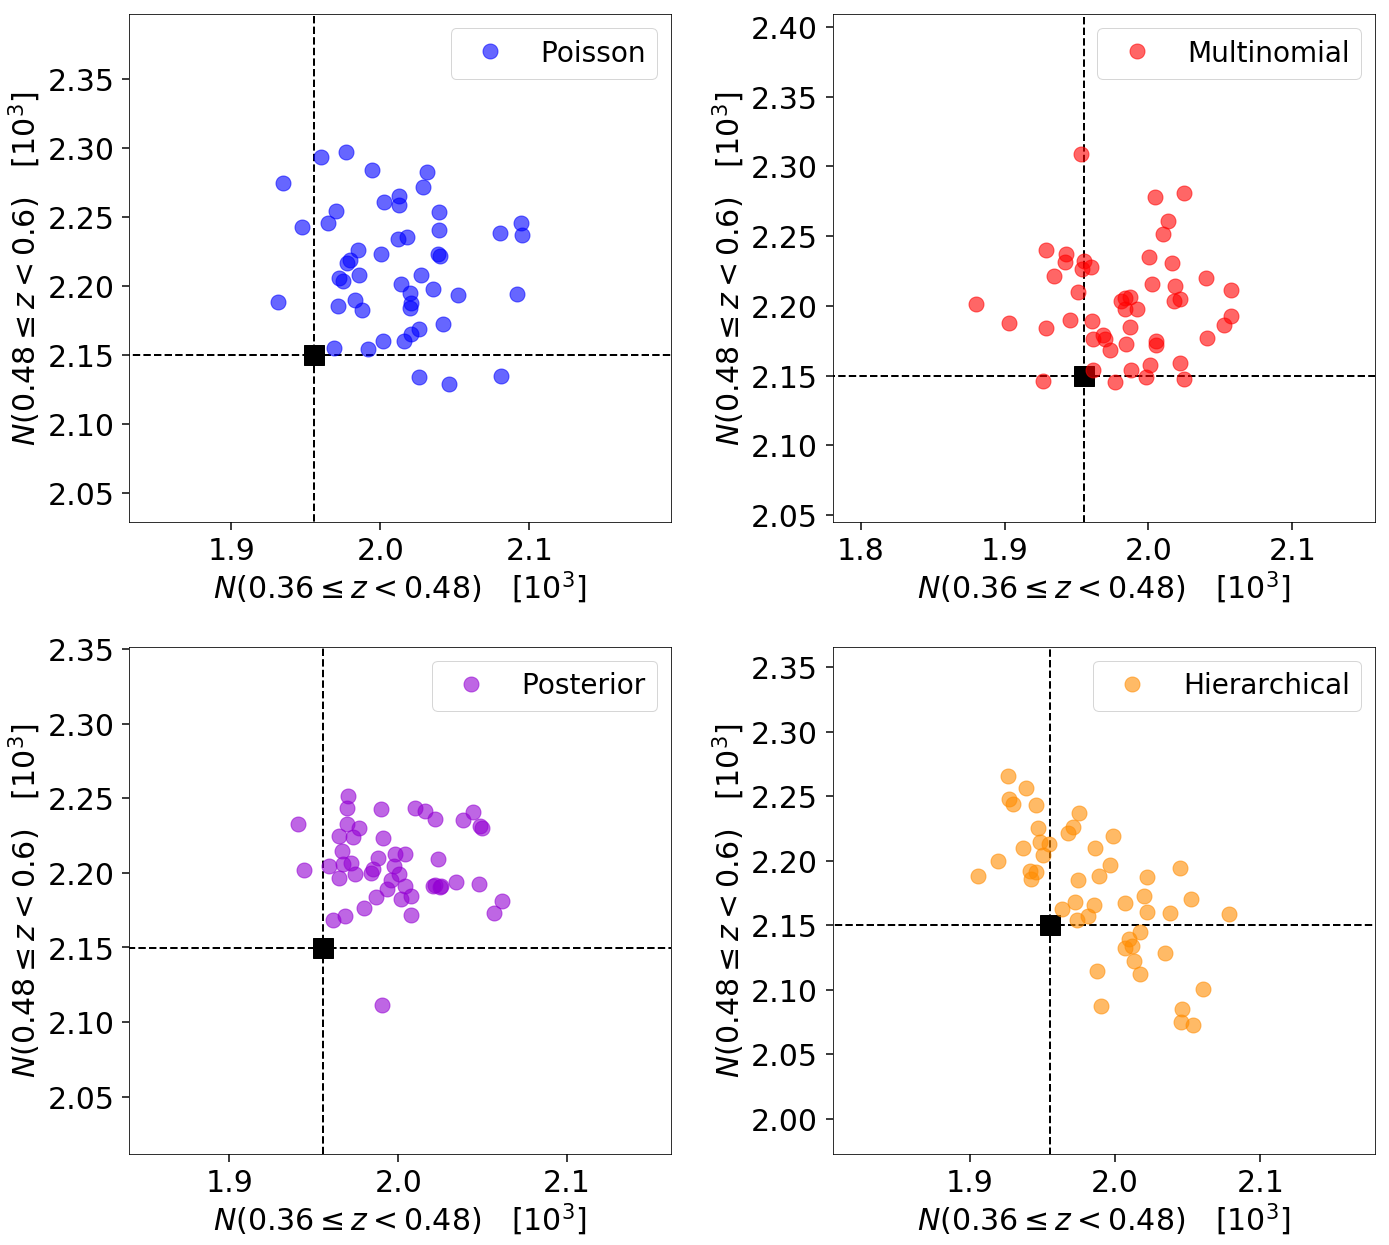

In [51]:
plt.figure(figsize=(20,18))
plt.subplot(2,2,1)
cov_draws(z1_samples, bin1=(60, 80), bin2=(80, 100),
          color='blue', label='Poisson')
plt.subplot(2,2,2)
cov_draws(z2_samples, bin1=(60, 80), bin2=(80, 100),
          color='red', label='Multinomial')
plt.subplot(2,2,3)
cov_draws(z3_samples, bin1=(60, 80), bin2=(80, 100),
          color='darkviolet', label='Posterior')
plt.subplot(2,2,4)
cov_draws(z4_samples[1:], bin1=(60, 80), bin2=(80, 100),
          color='darkorange', label='Hierarchical')

As with the original case, our hierarchical model appears to performs well, shifting the mean closer to the real solution and introducing more realistic covariances.